In [3]:
import torch
import matplotlib.pyplot as plt


In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import DataLoader, random_split


In [5]:
# download & load the dataset
transform = transforms.ToTensor()
#transform = transforms.Compose([
#    transforms.Grayscale(num_output_channels=3),
#    transforms.ToTensor()
#])


train_dataset = MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

val_dataset = MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



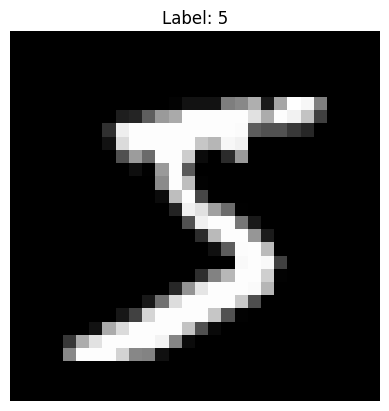

In [6]:
# Show the data
img, label = train_dataset[0]

plt.imshow(img.squeeze(), cmap="gray",interpolation="nearest")
plt.title(f"Label: {label}")
plt.axis("off")
plt.show()



In [7]:
img, _ = train_dataset[0]
print("Shape:", img.shape)
print("Min:", img.min().item(), "Max:", img.max().item())


Shape: torch.Size([1, 28, 28])
Min: 0.0 Max: 1.0


In [8]:
print(img.shape)


torch.Size([1, 28, 28])


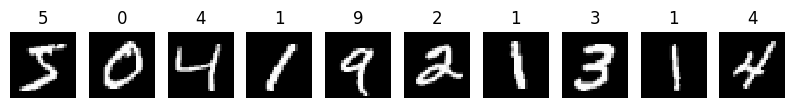

In [9]:
plt.figure(figsize=(10, 2))

for i in range(10):
    img, label = train_dataset[i]

    plt.subplot(1, 10, i + 1)
    plt.imshow(img.squeeze(), cmap="gray", interpolation="nearest")
    plt.title(label)
    plt.axis("off")

plt.show()


In [10]:
print("Number of images:", len(train_dataset))
print("Classes:", train_dataset.classes)


Number of images: 60000
Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


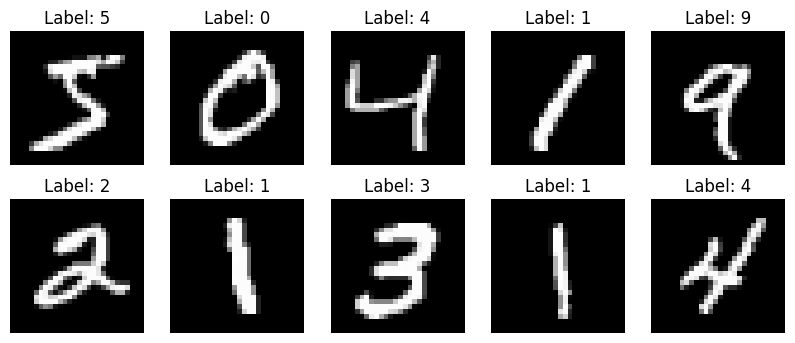

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.show()


In [12]:
from collections import Counter

labels = [label for _, label in train_dataset]
counts = Counter(labels)

for k in range(10):
    print(f"Digit {k}: {counts[k]}")


Digit 0: 5923
Digit 1: 6742
Digit 2: 5958
Digit 3: 6131
Digit 4: 5842
Digit 5: 5421
Digit 6: 5918
Digit 7: 6265
Digit 8: 5851
Digit 9: 5949


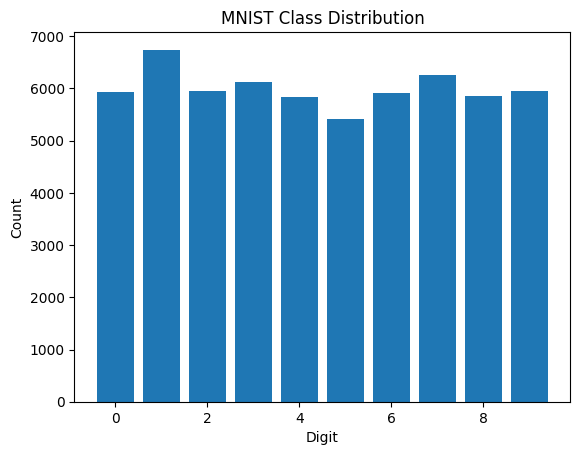

In [13]:
plt.bar(counts.keys(), counts.values())
plt.xlabel("Digit")
plt.ylabel("Count")
plt.title("MNIST Class Distribution")
plt.show()


It's mostly balanced class distribution 

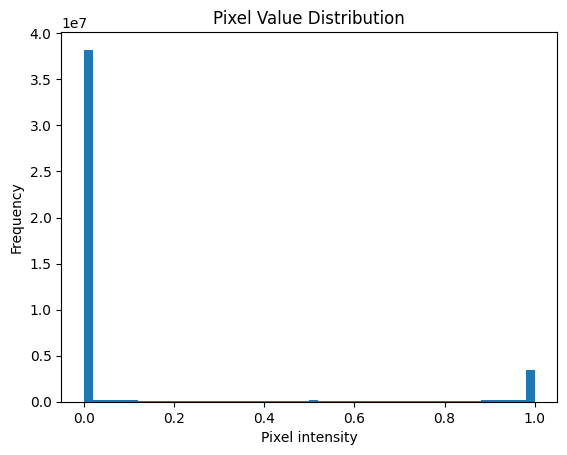

In [14]:
import torch

pixels = torch.cat([img.view(-1) for img, _ in train_dataset])

plt.hist(pixels.numpy(), bins=50)
plt.xlabel("Pixel intensity")
plt.ylabel("Frequency")
plt.title("Pixel Value Distribution")
plt.show()


In [15]:
mean = 0.0
std = 0.0

for img, _ in train_dataset:
    mean += img.mean()
    std += img.std()

mean /= len(train_dataset)
std /= len(train_dataset)

print("Mean:", mean.item())
print("Std:", std.item())


Mean: 0.13065974414348602
Std: 0.3015038073062897


In [16]:
import torch

class_images = {i: [] for i in range(10)}

for img, label in train_dataset:
    class_images[label].append(img)

avg_images = {
    k: torch.mean(torch.stack(v), dim=0)
    for k, v in class_images.items()
}


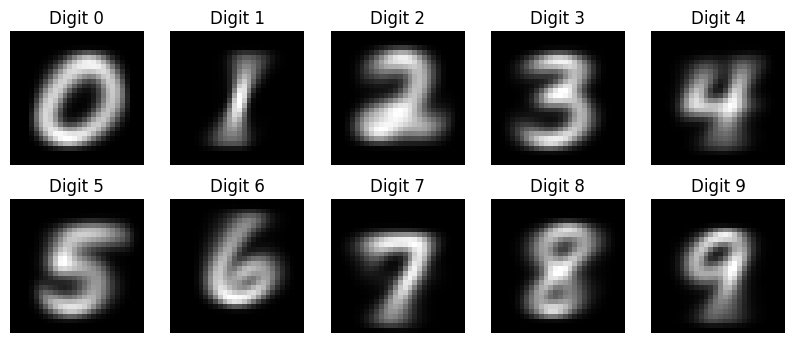

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i, ax in enumerate(axes.flat):
    ax.imshow(avg_images[i].squeeze(), cmap="gray")
    ax.set_title(f"Digit {i}")
    ax.axis("off")

plt.show()


images are blurry 

In [18]:
var_images = {
    k: torch.var(torch.stack(v), dim=0)
    for k, v in class_images.items()
}
#var_images 

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [20]:
class MNIST_CNN(nn.Module):
    def __init__(
        self,
        use_dropout=False,
        extra_fc=False,
        extra_conv=False,
        dropout_p=0.5
    ):
        super().__init__()

        # ----- Convolutional layers -----
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)

        self.extra_conv = extra_conv
        if extra_conv:
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # ----- Fully connected layers -----
        conv_output_channels = 64 if extra_conv else 32
        self.fc1 = nn.Linear(conv_output_channels * 7 * 7, 128)

        self.extra_fc = extra_fc
        if extra_fc:
            self.fc_extra = nn.Linear(128, 64)

        self.fc2 = nn.Linear(64 if extra_fc else 128, 10)

        # ----- Dropout -----
        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        if self.extra_conv:
            x = F.relu(self.conv3(x))

        x = x.reshape(x.size(0), -1)

        x = F.relu(self.fc1(x))
        if self.use_dropout:
            x = self.dropout(x)

        if self.extra_fc:
            x = F.relu(self.fc_extra(x))
            if self.use_dropout:
                x = self.dropout(x)

        x = self.fc2(x)
        return x


In [21]:
#TRaining and evaulation functions

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)


In [22]:
def evaluate_model(model, val_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total


In [23]:
#Run multiple variation

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

experiments = [
    {"name": "Baseline", "use_dropout": False, "extra_fc": False, "extra_conv": False},
    {"name": "Dropout only", "use_dropout": True, "extra_fc": False, "extra_conv": False},
    {"name": "Extra FC", "use_dropout": False, "extra_fc": True, "extra_conv": False},
    {"name": "Extra Conv", "use_dropout": False, "extra_fc": False, "extra_conv": True},
    {"name": "Dropout + Extra FC", "use_dropout": True, "extra_fc": True, "extra_conv": False},
    {"name": "Dropout + Extra Conv", "use_dropout": True, "extra_fc": False, "extra_conv": True},
    {"name": "All features", "use_dropout": True, "extra_fc": True, "extra_conv": True},
]

epochs = 5

for exp in experiments:
    print(f"\n🔹 Training: {exp['name']}")

    model = MNIST_CNN(
        use_dropout=exp["use_dropout"],
        extra_fc=exp["extra_fc"],
        extra_conv=exp["extra_conv"]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        loss = train_model(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    acc = evaluate_model(model, val_loader, device)
    print(f"✅ Validation Accuracy: {acc:.2f}%")



🔹 Training: Baseline
Epoch 1/5, Loss: 0.2537
Epoch 2/5, Loss: 0.0661
Epoch 3/5, Loss: 0.0462
Epoch 4/5, Loss: 0.0356
Epoch 5/5, Loss: 0.0283
✅ Validation Accuracy: 98.74%

🔹 Training: Dropout only
Epoch 1/5, Loss: 0.3203
Epoch 2/5, Loss: 0.1105
Epoch 3/5, Loss: 0.0827
Epoch 4/5, Loss: 0.0728
Epoch 5/5, Loss: 0.0617
✅ Validation Accuracy: 98.83%

🔹 Training: Extra FC
Epoch 1/5, Loss: 0.2800
Epoch 2/5, Loss: 0.0745
Epoch 3/5, Loss: 0.0515
Epoch 4/5, Loss: 0.0390
Epoch 5/5, Loss: 0.0303
✅ Validation Accuracy: 98.66%

🔹 Training: Extra Conv
Epoch 1/5, Loss: 0.1974
Epoch 2/5, Loss: 0.0533
Epoch 3/5, Loss: 0.0369
Epoch 4/5, Loss: 0.0281
Epoch 5/5, Loss: 0.0219
✅ Validation Accuracy: 99.09%

🔹 Training: Dropout + Extra FC
Epoch 1/5, Loss: 0.5611
Epoch 2/5, Loss: 0.1935
Epoch 3/5, Loss: 0.1479
Epoch 4/5, Loss: 0.1227
Epoch 5/5, Loss: 0.1092
✅ Validation Accuracy: 98.83%

🔹 Training: Dropout + Extra Conv
Epoch 1/5, Loss: 0.2719
Epoch 2/5, Loss: 0.0878
Epoch 3/5, Loss: 0.0630
Epoch 4/5, Loss: 0

In [24]:
learning_rates = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4]


In [25]:
#training with learning rate(LR) tuning

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

epochs = 5

results = {}

for lr in learning_rates:
    print(f"\n🔹 Training with learning rate = {lr}")

    model = MNIST_CNN(
        use_dropout=True,
        extra_fc=True,
        extra_conv=True
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        loss = train_model(model, train_loader, optimizer, criterion, device)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

    acc = evaluate_model(model, val_loader, device)
    results[lr] = acc
    print(f"✅ Validation Accuracy: {acc:.2f}%")



🔹 Training with learning rate = 0.1
Epoch 1/5, Loss: 4.6759
Epoch 2/5, Loss: 2.3106
Epoch 3/5, Loss: 2.3095
Epoch 4/5, Loss: 2.3092
Epoch 5/5, Loss: 2.3101
✅ Validation Accuracy: 9.58%

🔹 Training with learning rate = 0.05
Epoch 1/5, Loss: 2.4771
Epoch 2/5, Loss: 2.3059
Epoch 3/5, Loss: 2.3056
Epoch 4/5, Loss: 2.3058
Epoch 5/5, Loss: 2.3058
✅ Validation Accuracy: 10.10%

🔹 Training with learning rate = 0.01
Epoch 1/5, Loss: 0.4123
Epoch 2/5, Loss: 0.2488
Epoch 3/5, Loss: 0.2299
Epoch 4/5, Loss: 0.2285
Epoch 5/5, Loss: 0.2293
✅ Validation Accuracy: 97.44%

🔹 Training with learning rate = 0.005
Epoch 1/5, Loss: 0.4184
Epoch 2/5, Loss: 0.1755
Epoch 3/5, Loss: 0.1460
Epoch 4/5, Loss: 0.1375
Epoch 5/5, Loss: 0.1291
✅ Validation Accuracy: 98.41%

🔹 Training with learning rate = 0.001
Epoch 1/5, Loss: 0.5125
Epoch 2/5, Loss: 0.1722
Epoch 3/5, Loss: 0.1236
Epoch 4/5, Loss: 0.0988
Epoch 5/5, Loss: 0.0851
✅ Validation Accuracy: 99.06%

🔹 Training with learning rate = 0.0005
Epoch 1/5, Loss: 0.5

In [26]:
#print best learning rate

best_lr = max(results, key=results.get)
print("\n🏆 Best Learning Rate:")
for lr, acc in results.items():
    print(f"LR={lr:.0e} → Accuracy={acc:.2f}%")

print(f"\nBest LR = {best_lr}, Accuracy = {results[best_lr]:.2f}%")



🏆 Best Learning Rate:
LR=1e-01 → Accuracy=9.58%
LR=5e-02 → Accuracy=10.10%
LR=1e-02 → Accuracy=97.44%
LR=5e-03 → Accuracy=98.41%
LR=1e-03 → Accuracy=99.06%
LR=5e-04 → Accuracy=98.91%
LR=1e-04 → Accuracy=96.73%

Best LR = 0.001, Accuracy = 99.06%
